In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, Voronoi, voronoi_plot_2d
import sys
import pathlib

from dijkstra_search import DijkstraSearch

In [87]:

class VoronoiRoadMapPlanner:

    def __init__(self):
        # parameter
        self.N_KNN = 15  # number of edge from one sampled point
        self.MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

    def planning(self, sx, sy, gx, gy, ox, oy, robot_radius):
        obstacle_tree = cKDTree(np.vstack((ox, oy)).T)

        sample_x, sample_y = self.voronoi_sampling(sx, sy, gx, gy, ox, oy)

        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "^r")
        plt.plot(gx, gy, "^c")
        plt.grid(True)
        plt.axis("equal")
        plt.plot(sample_x, sample_y, ".b")

        road_map_info = self.generate_road_map_info(
            sample_x, sample_y, robot_radius, obstacle_tree)

        rx, ry = DijkstraSearch(False).search(sx, sy, gx, gy,
                                                       sample_x, sample_y,
                                                       road_map_info)
        return rx, ry

    def is_collision(self, sx, sy, gx, gy, rr, obstacle_kd_tree):
        x = sx
        y = sy
        dx = gx - sx
        dy = gy - sy
        yaw = math.atan2(gy - sy, gx - sx)
        d = math.hypot(dx, dy)

        if d >= self.MAX_EDGE_LEN:
            return True

        D = rr
        n_step = round(d / D)

        for i in range(n_step):
            dist, _ = obstacle_kd_tree.query([x, y])
            if dist <= rr:
                return True  # collision
            x += D * math.cos(yaw)
            y += D * math.sin(yaw)

        # goal point check
        dist, _ = obstacle_kd_tree.query([gx, gy])
        if dist <= rr:
            return True  # collision

        return False  # OK

    def generate_road_map_info(self, node_x, node_y, rr, obstacle_tree):
        """
        Road map generation

        node_x: [m] x positions of sampled points
        node_y: [m] y positions of sampled points
        rr: Robot Radius[m]
        obstacle_tree: KDTree object of obstacles
        """

        # road_map_info = self.generate_road_map_info(
        # sample_x, sample_y, robot_radius, obstacle_tree)

        road_map = []
        n_sample = len(node_x)
        node_tree = cKDTree(np.vstack((node_x, node_y)).T)

        for (i, ix, iy) in zip(range(n_sample), node_x, node_y):

            dists, indexes = node_tree.query([ix, iy], k=n_sample)

            edge_id = []

            for ii in range(1, len(indexes)):
                nx = node_x[indexes[ii]]
                ny = node_y[indexes[ii]]

                if not self.is_collision(ix, iy, nx, ny, rr, obstacle_tree):
                    edge_id.append(indexes[ii])

                if len(edge_id) >= self.N_KNN:
                    break

            road_map.append(edge_id)

        self.plot_road_map(road_map, node_x, node_y)

        return road_map

    @staticmethod
    def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

        for i, _ in enumerate(road_map):
            for ii in range(len(road_map[i])):
                ind = road_map[i][ii]

                plt.plot([sample_x[i], sample_x[ind]],
                         [sample_y[i], sample_y[ind]], "-k")

    @staticmethod
    def voronoi_sampling(sx, sy, gx, gy, ox, oy):
        oxy = np.vstack((ox, oy)).T

        # generate voronoi point
        vor = Voronoi(oxy)
        # fig = voronoi_plot_2d(vor)
        # plt.show()
        sample_x = [ix for [ix, _] in vor.vertices]
        sample_y = [iy for [_, iy] in vor.vertices]

        sample_x.append(sx)
        sample_y.append(sy)
        sample_x.append(gx)
        sample_y.append(gy)

        return sample_x, sample_y


In [88]:
obstacleList = [
    [-5.6749, 1.20558, 0.521155],
    [-3.42783, -2.3167, 0.620818],
    [2.07, 5.36304, 0.534224],
    [-2.02172, -3.82217, 0.462809],
    [1.09052, -0.990239, 0.644405],
    [-4, 6.92, 0.01],
    [-4, 6.92, 0.01],
    [-3.6, 6.92, 0.01],
    [-3.2, 6.92, 0.01],
    [-2.8, 6.92, 0.01],
    [-2.4, 6.92, 0.01],
    [-2, 6.92, 0.01],
    [-1.6, 6.92, 0.01],
    [-1.2, 6.92, 0.01],
    [-0.8, 6.92, 0.01],
    [-0.4, 6.92, 0.01],
    [0, 6.92, 0.01],
    [0.4, 6.92, 0.01],
    [0.8, 6.92, 0.01],
    [1.2, 6.92, 0.01],
    [1.6, 6.92, 0.01],
    [2, 6.92, 0.01],
    [2.4, 6.92, 0.01],
    [2.8, 6.92, 0.01],
    [3.2, 6.92, 0.01],
    [3.6, 6.92, 0.01],
    [4, 6.92, 0.01],
    [4.2, 6.574, 0.01],
    [4.4, 6.228, 0.01],
    [4.6, 5.882, 0.01],
    [4.8, 5.536, 0.01],
    [5, 5.19, 0.01],
    [5.2, 4.844, 0.01],
    [5.4, 4.498, 0.01],
    [5.6, 4.152, 0.01],
    [5.8, 3.806, 0.01],
    [6, 3.46, 0.01],
    [6.2, 3.114, 0.01],
    [6.4, 2.768, 0.01],
    [6.6, 2.422, 0.01],
    [6.8, 2.076, 0.01],
    [7, 1.73, 0.01],
    [7.2, 1.384, 0.01],
    [7.4, 1.038, 0.01],
    [7.6, 0.692, 0.01],
    [7.8, 0.346, 0.01],
    [8, 0, 0.01],
    [7.8, -0.346, 0.01],
    [7.6, -0.692, 0.01],
    [7.4, -1.038, 0.01],
    [7.2, -1.384, 0.01],
    [7, -1.73, 0.01],
    [6.8, -2.076, 0.01],
    [6.6, -2.422, 0.01],
    [6.4, -2.768, 0.01],
    [6.2, -3.114, 0.01],
    [6, -3.46, 0.01],
    [5.8, -3.806, 0.01],
    [5.6, -4.152, 0.01],
    [5.4, -4.498, 0.01],
    [5.2, -4.844, 0.01],
    [5, -5.19, 0.01],
    [4.8, -5.536, 0.01],
    [4.6, -5.882, 0.01],
    [4.4, -6.228, 0.01],
    [4.2, -6.574, 0.01],
    [4, -6.92, 0.01],
    [3.6, -6.92, 0.01],
    [3.2, -6.92, 0.01],
    [2.8, -6.92, 0.01],
    [2.4, -6.92, 0.01],
    [2, -6.92, 0.01],
    [1.6, -6.92, 0.01],
    [1.2, -6.92, 0.01],
    [0.8, -6.92, 0.01],
    [0.4, -6.92, 0.01],
    [0, -6.92, 0.01],
    [-0.4, -6.92, 0.01],
    [-0.8, -6.92, 0.01],
    [-1.2, -6.92, 0.01],
    [-1.6, -6.92, 0.01],
    [-2, -6.92, 0.01],
    [-2.4, -6.92, 0.01],
    [-2.8, -6.92, 0.01],
    [-3.2, -6.92, 0.01],
    [-3.6, -6.92, 0.01],
    [-4, -6.92, 0.01],
    [-4.2, -6.574, 0.01],
    [-4.4, -6.228, 0.01],
    [-4.6, -5.882, 0.01],
    [-4.8, -5.536, 0.01],
    [-5, -5.19, 0.01],
    [-5.2, -4.844, 0.01],
    [-5.4, -4.498, 0.01],
    [-5.6, -4.152, 0.01],
    [-5.8, -3.806, 0.01],
    [-6, -3.46, 0.01],
    [-6.2, -3.114, 0.01],
    [-6.4, -2.768, 0.01],
    [-6.6, -2.422, 0.01],
    [-6.8, -2.076, 0.01],
    [-7, -1.73, 0.01],
    [-7.2, -1.384, 0.01],
    [-7.4, -1.038, 0.01],
    [-7.6, -0.692, 0.01],
    [-7.8, -0.346, 0.01],
    [-8, 0, 0.01],
    [-7.8, 0.346, 0.01],
    [-7.6, 0.692, 0.01],
    [-7.4, 1.038, 0.01],
    [-7.2, 1.384, 0.01],
    [-7, 1.73, 0.01],
    [-6.8, 2.076, 0.01],
    [-6.6, 2.422, 0.01],
    [-6.4, 2.768, 0.01],
    [-6.2, 3.114, 0.01],
    [-6, 3.46, 0.01],
    [-5.8, 3.806, 0.01],
    [-5.6, 4.152, 0.01],
    [-5.4, 4.498, 0.01],
    [-5.2, 4.844, 0.01],
    [-5, 5.19, 0.01],
    [-4.8, 5.536, 0.01],
    [-4.6, 5.882, 0.01],
    [-4.4, 6.228, 0.01],
    [-4.2, 6.574, 0.01],
]

[[43, 1, 63, 64, 44, 18, 65, 4, 15, 123, 19, 14, 59, 58, 2], [63, 43, 64, 18, 65, 4, 19, 44, 59, 58, 0, 17, 15, 57, 60], [123, 0, 75, 74, 76, 25, 71, 27, 72, 28, 82, 80, 73, 81, 83], [12, 32, 30, 86, 29, 85, 11, 13, 31, 40, 38, 84, 39, 83, 35], [65, 43, 63, 1, 64, 18, 59, 58, 19, 44, 17, 57, 60, 15, 0], [8, 21, 9, 20, 10, 7, 23, 6, 66, 22, 120, 67, 110, 119, 111], [66, 120, 7, 67, 20, 101, 119, 21, 102, 5, 70, 97, 8, 99, 9], [20, 6, 66, 120, 21, 67, 5, 119, 101, 8, 102, 9, 97, 70, 10], [9, 5, 10, 21, 23, 20, 22, 7, 110, 6, 111, 24, 66, 26, 108], [8, 10, 5, 23, 21, 22, 20, 110, 111, 24, 26, 7, 108, 109, 27], [9, 23, 8, 22, 5, 110, 111, 24, 21, 26, 108, 109, 27, 20, 107], [13, 29, 40, 38, 30, 39, 35, 37, 12, 3, 32, 36, 86, 34, 85], [3, 32, 30, 86, 29, 85, 11, 13, 31, 40, 38, 84, 39, 35, 83], [11, 40, 38, 29, 39, 30, 35, 37, 36, 12, 3, 32, 34, 86, 85], [42, 15, 41, 44, 33, 34, 58, 59, 4, 65, 57, 60, 36, 43, 1], [14, 44, 42, 4, 65, 59, 58, 43, 1, 63, 41, 64, 57, 60, 0], [45, 17, 46, 19, 87

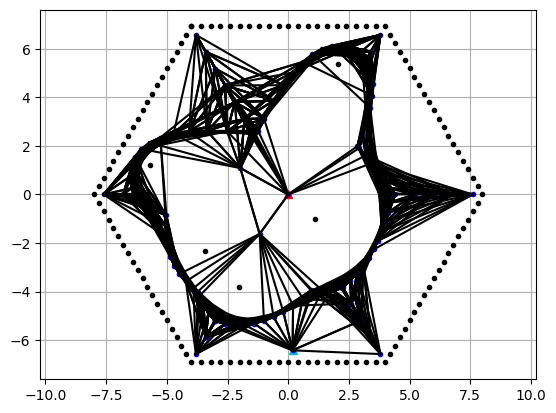

In [89]:
# start and goal position
sx = 0 # [m]
sy = 0  # [m]
gx = .18  # [m]
gy = -6.42  # [m]
robot_size = 0.363 # [m]

ox = []
oy = []

for (obs_x, obs_y, s) in obstacleList:
    ox.append(obs_x)
    oy.append(obs_y)


rx, ry = VoronoiRoadMapPlanner().planning(sx, sy, gx, gy, ox, oy,
                                          robot_size)

assert rx, 'Cannot found path'

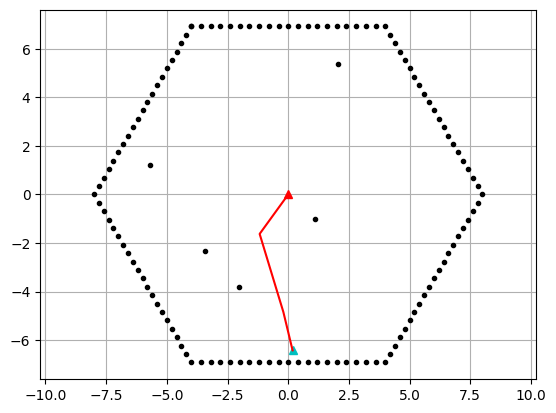

In [77]:
plt.plot(ox, oy, ".k")
plt.plot(sx, sy, "^r")
plt.plot(gx, gy, "^c")
plt.grid(True)
plt.axis("equal")
plt.plot(rx, ry, "-r")
plt.pause(0.1)
plt.show()